# 查看FashionMNIST原始数据格式

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from wangdao_deeplearning_train import EarlyStopping, ModelSaver,train_classification_model,plot_learning_curves
from wangdao_deeplearning_train import evaluate_classification_model as evaluate_model

# 加载数据并处理为tensor

In [2]:
from pathlib import Path

DATA_DIR = Path("./archive/")

# 定义数据预处理
data_transforms = {
    'training': transforms.Compose([
        transforms.Resize((128, 128)),  # 调整图像大小为128x128
        transforms.ToTensor(),  # 将图像转换为Tensor
        transforms.Normalize(mean=[0.4363, 0.4328, 0.3291], std=[0.2085, 0.2032, 0.1988])  # 标准化，使用ImageNet的均值和标准差
    ]),
    'validation': transforms.Compose([
        transforms.Resize((128, 128)),  # 调整图像大小为128x128
        transforms.ToTensor(),  # 将图像转换为Tensor
        transforms.Normalize(mean=[0.4363, 0.4328, 0.3291], std=[0.2085, 0.2032, 0.1988])  # 标准化，使用ImageNet的均值和标准差
    ]),
}

# 使用ImageFolder加载数据
# ImageFolder假设数据集按照如下方式组织：root/class/image.jpg
train_dataset = datasets.ImageFolder(
    root=DATA_DIR / 'training',
    transform=data_transforms['training']
)

test_dataset = datasets.ImageFolder(
    root=DATA_DIR / 'validation',
    transform=data_transforms['validation']
)

# 打印类别信息
class_names = train_dataset.classes
print(f"类别数量: {len(class_names)}")
print(f"类别名称: {class_names}")

# 查看一个样本
img, label = train_dataset[0]
print(f"图像形状: {img.shape}")  # 应该是[3, 128, 128]
print(f"标签: {label} (类别: {class_names[label]})")


类别数量: 10
类别名称: ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']
图像形状: torch.Size([3, 128, 128])
标签: 0 (类别: n0)


In [3]:
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds: #img是图像，_是标签
        mean += img.mean(dim=(1, 2)) #dim=(1, 2)表示在通道维度上求平均
        std += img.std(dim=(1, 2))  #dim=(1, 2)表示在通道维度上求标准差
    mean /= len(ds)
    std /= len(ds)
    return mean, std
cal_mean_std(train_dataset)

(tensor([ 1.5299e-04,  3.6267e-05, -6.5391e-07]),
 tensor([0.9999, 0.9999, 1.0002]))

# 把数据集划分为训练集55000和验证集5000，并给DataLoader

In [4]:


# 创建数据加载器
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True #打乱数据集，每次迭代时，数据集的顺序都会被打乱
)

val_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# 打印数据集大小信息
print(f"训练集大小: {len(train_dataset)}")
print(f"测试集大小: {len(test_dataset)}")
print(f"批次大小: {batch_size}")
print(f"训练批次数: {len(train_loader)}")


训练集大小: 1097
测试集大小: 272
批次大小: 32
训练批次数: 35


In [5]:
64*860

55040

# 搭建模型

In [6]:

#理解每个接口的方法，单独写例子
import torch.nn as nn
m=nn.BatchNorm1d(100) # 创建一个批量归一化层，输入特征维度为100
x=torch.randn(20,100) # 创建一个20行100列的随机张量
print(m(x).shape) # 打印批量归一化后的张量形状

torch.Size([20, 100])


# 解析padding超参

In [7]:
# 初始化一个5*5的卷积层，保持输入输出图像尺寸不变
# 要保持尺寸不变，需要设置适当的padding
# 对于kernel_size=5的卷积，需要padding=2才能保持尺寸不变

import torch
import torch.nn as nn

# 创建一个卷积层，输入通道为1，输出通道为16，卷积核大小为5x5，padding为2,步长为2
conv = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2,stride=2)

# 创建卷积层
# padding='same' 表示使用动态padding，保持输入输出图像尺寸不变,为same时，步长只能为1
# padding='valid' 表示不使用padding，输出图像尺寸会变小

# 创建一个随机输入张量，模拟一个批次的单通道图像，比如28x28的MNIST图像
input_tensor = torch.randn(1, 1, 28, 28)  # [批次大小, 通道数, 高度, 宽度]

# 进行卷积操作
output = conv(input_tensor)

# 打印输入和输出的形状，验证尺寸是否保持不变
print(f"输入张量形状: {input_tensor.shape}")
print(f"输出张量形状: {output.shape}")
print(f"卷积层参数: kernel_size={conv.kernel_size}, padding={conv.padding}, stride={conv.stride}")


输入张量形状: torch.Size([1, 1, 28, 28])
输出张量形状: torch.Size([1, 16, 14, 14])
卷积层参数: kernel_size=(5, 5), padding=(2, 2), stride=(2, 2)


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # 第一组卷积层 - 32个卷积核
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # 输入通道数，输出通道数代表的是卷积核的个数
        
        # 深度可分离卷积替代conv2
        self.depthwise2 = nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32)
        self.pointwise2 = nn.Conv2d(32, 32, kernel_size=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # 第二组卷积层 - 64个卷积核
        # 深度可分离卷积替代conv3
        self.depthwise3 = nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32)
        self.pointwise3 = nn.Conv2d(32, 64, kernel_size=1)
        
        # 深度可分离卷积替代conv4
        self.depthwise4 = nn.Conv2d(64, 64, kernel_size=3, padding=1, groups=64)
        self.pointwise4 = nn.Conv2d(64, 64, kernel_size=1)

        # 第三组卷积层 - 128个卷积核
        # 深度可分离卷积替代conv5
        self.depthwise5 = nn.Conv2d(64, 64, kernel_size=3, padding=1, groups=64)
        self.pointwise5 = nn.Conv2d(64, 128, kernel_size=1)
        
        # 深度可分离卷积替代conv6
        self.depthwise6 = nn.Conv2d(128, 128, kernel_size=3, padding=1, groups=128)
        self.pointwise6 = nn.Conv2d(128, 128, kernel_size=1)

        # 计算全连接层的输入特征数
        # 经过3次池化，图像尺寸从28x28变为3x3x128
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 10)

        # 初始化权重
        self.init_weights()

    def init_weights(self):
        """使用 xavier 均匀分布来初始化卷积层和全连接层的权重"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        # x.shape [batch size, 1, 28, 28]

        # 第一组卷积层
        x = F.selu(self.conv1(x))
        # print(f"conv1后的形状: {x.shape}")
        
        # 深度可分离卷积替代conv2
        x = F.selu(self.depthwise2(x))
        x = F.selu(self.pointwise2(x))
        # print(f"conv2后的形状: {x.shape}")
        
        x = self.pool(x)
        # print(f"pool1后的形状: {x.shape}")

        # 第二组卷积层
        # 深度可分离卷积替代conv3
        x = F.selu(self.depthwise3(x))
        x = F.selu(self.pointwise3(x))
        # print(f"conv3后的形状: {x.shape}")
        
        # 深度可分离卷积替代conv4
        x = F.selu(self.depthwise4(x))
        x = F.selu(self.pointwise4(x))
        # print(f"conv4后的形状: {x.shape}")
        
        x = self.pool(x)
        # print(f"pool2后的形状: {x.shape}")

        # 第三组卷积层
        # 深度可分离卷积替代conv5
        x = F.selu(self.depthwise5(x))
        x = F.selu(self.pointwise5(x))
        # print(f"conv5后的形状: {x.shape}")
        
        # 深度可分离卷积替代conv6
        x = F.selu(self.depthwise6(x))
        x = F.selu(self.pointwise6(x))
        # print(f"conv6后的形状: {x.shape}")
        
        x = self.pool(x)
        # print(f"pool3后的形状: {x.shape}")

        # 展平
        x = x.view(x.size(0), -1)
        # print(f"展平后的形状: {x.shape}")

        # 全连接层
        x = F.selu(self.fc1(x))
        # print(f"fc1后的形状: {x.shape}")
        x = self.fc2(x)
        # print(f"fc2后的形状: {x.shape}")

        return x

In [9]:
# 实例化模型
model = NeuralNetwork()

# 从train_loader获取第一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 查看批次数据的形状
print("批次图像形状:", images.shape)
print("批次标签形状:", labels.shape)


print('-'*100)
# 进行前向传播
with torch.no_grad():  # 不需要计算梯度
    outputs = model(images)


print(outputs.shape)

批次图像形状: torch.Size([32, 3, 128, 128])
批次标签形状: torch.Size([32])
----------------------------------------------------------------------------------------------------
torch.Size([32, 10])


In [10]:
# 计算模型的总参数量
# 统计需要求梯度的参数总量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"需要求梯度的参数总量: {total_params}")

# 统计所有参数总量
all_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {all_params}")

# 查看每层参数量明细
print("\n各层参数量明细:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} 参数")

需要求梯度的参数总量: 8427690
模型总参数量: 8427690

各层参数量明细:
conv1.weight: 864 参数
conv1.bias: 32 参数
depthwise2.weight: 288 参数
depthwise2.bias: 32 参数
pointwise2.weight: 1024 参数
pointwise2.bias: 32 参数
depthwise3.weight: 288 参数
depthwise3.bias: 32 参数
pointwise3.weight: 2048 参数
pointwise3.bias: 64 参数
depthwise4.weight: 576 参数
depthwise4.bias: 64 参数
pointwise4.weight: 4096 参数
pointwise4.bias: 64 参数
depthwise5.weight: 576 参数
depthwise5.bias: 64 参数
pointwise5.weight: 8192 参数
pointwise5.bias: 128 参数
depthwise6.weight: 1152 参数
depthwise6.bias: 128 参数
pointwise6.weight: 16384 参数
pointwise6.bias: 128 参数
fc1.weight: 8388608 参数
fc1.bias: 256 参数
fc2.weight: 2560 参数
fc2.bias: 10 参数


In [11]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 2.9536e-02, -1.7215e-02, -7.9833e-02],
                        [-1.1365e-01, -8.4613e-02,  6.4580e-02],
                        [ 6.4926e-02, -1.6395e-02, -5.8692e-03]],
              
                       [[-1.0588e-01, -1.3761e-01,  9.1554e-03],
                        [ 1.0191e-01, -9.3735e-02, -8.6729e-02],
                        [-4.5120e-02,  6.3000e-02,  5.2375e-02]],
              
                       [[-5.4093e-02, -1.1113e-01,  1.0257e-01],
                        [ 1.0450e-01,  1.2528e-01, -8.7956e-02],
                        [-5.8075e-02,  7.7554e-02, -6.2330e-02]]],
              
              
                      [[[-7.5522e-02, -3.9398e-02, -6.4872e-02],
                        [-4.3917e-03,  6.0013e-02, -1.3260e-01],
                        [ 1.2795e-01,  1.0257e-02, -1.1999e-01]],
              
                       [[-9.2448e-02, -5.9879e-02, -1.0200e-01],
                        [ 1.3713e-01, -1.7048

In [12]:
from torch.utils.tensorboard import SummaryWriter
class TensorboardLogger:
    """
    Tensorboard日志记录类：记录训练过程中的损失和准确率
    
    参数:
        log_dir: 日志保存目录,log_dir的父目录不要有中文
    """
    def __init__(self, log_dir='tensorboard_logs'):

        import os
        
        # 确保日志目录存在
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)
            
        self.writer = SummaryWriter(log_dir) # 实例化SummaryWriter, log_dir是log存放路径，flush_secs是每隔多少秒写入磁盘
        
    def log_training(self, epoch, train_loss, train_acc):
        """
        记录训练数据
        
        参数:
            epoch: 当前训练轮数
            train_loss: 训练损失
            train_acc: 训练准确率
        """
        self.writer.add_scalar('训练/损失', train_loss, epoch)
        self.writer.add_scalar('训练/准确率', train_acc, epoch)
        
    def log_validation(self, epoch, val_loss, val_acc):
        """
        记录验证数据
        
        参数:
            epoch: 当前训练轮数
            val_loss: 验证损失
            val_acc: 验证准确率
        """
        self.writer.add_scalar('验证/损失', val_loss, epoch)
        self.writer.add_scalar('验证/准确率', val_acc, epoch)
    
    def log_lr(self, epoch, lr):
        """
        记录学习率
        
        参数:
            epoch: 当前训练轮数
            lr: 学习率
        """
        self.writer.add_scalar('学习率', lr, epoch)
        
    def log_model_graph(self, model, images):
        """
        记录模型结构图
        
        参数:
            model: 模型
            images: 输入图像样本
        """
        self.writer.add_graph(model, images)
        
    def close(self):
        """
        关闭Tensorboard写入器
        """
        self.writer.close()


# 设置交叉熵损失函数，SGD优化器

In [13]:
model = NeuralNetwork()
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码

print("损失函数:", loss_fn)


损失函数: CrossEntropyLoss()


In [14]:
model = NeuralNetwork()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD优化器，学习率为0.01，动量为0.9

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU
early_stopping=EarlyStopping(patience=10, delta=0.001)
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True)
tensorboard_logger=TensorboardLogger(log_dir='logs')

model, history = train_classification_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50, early_stopping=early_stopping, model_saver=model_saver, tensorboard_logger=tensorboard_logger)



使用设备: cpu
训练开始，共1750步


  0%|          | 0/1750 [00:00<?, ?it/s]

早停触发! 最佳验证准确率(如果是回归，这里是损失): 56.2500
早停: 在1700 步


In [16]:
history['train'][-100:-1]

[{'loss': 0.0244493056088686, 'acc': 100.0, 'step': 1601},
 {'loss': 0.015628209337592125, 'acc': 100.0, 'step': 1602},
 {'loss': 0.0302165225148201, 'acc': 100.0, 'step': 1603},
 {'loss': 0.028941577300429344, 'acc': 100.0, 'step': 1604},
 {'loss': 0.03200396150350571, 'acc': 100.0, 'step': 1605},
 {'loss': 0.014572709798812866, 'acc': 100.0, 'step': 1606},
 {'loss': 0.021114032715559006, 'acc': 100.0, 'step': 1607},
 {'loss': 0.020425351336598396, 'acc': 100.0, 'step': 1608},
 {'loss': 0.01535417977720499, 'acc': 100.0, 'step': 1609},
 {'loss': 0.01704162359237671, 'acc': 100.0, 'step': 1610},
 {'loss': 0.014250325970351696, 'acc': 100.0, 'step': 1611},
 {'loss': 0.01552823930978775, 'acc': 100.0, 'step': 1612},
 {'loss': 0.02124432846903801, 'acc': 100.0, 'step': 1613},
 {'loss': 0.017624514177441597, 'acc': 100.0, 'step': 1614},
 {'loss': 0.023377973586320877, 'acc': 100.0, 'step': 1615},
 {'loss': 0.026866529136896133, 'acc': 100.0, 'step': 1616},
 {'loss': 0.02314138226211071, 'a

# 绘制损失曲线和准确率曲线

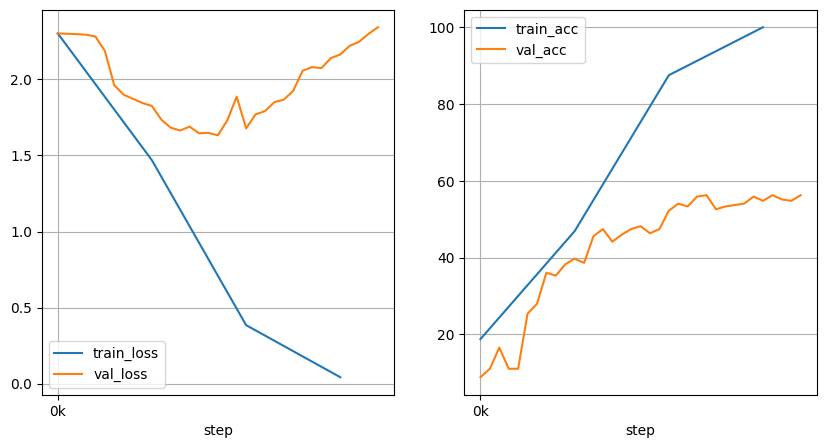

In [19]:
plot_learning_curves(history, sample_step=500)  #横坐标是 steps

In [20]:
# 在测试集上评估模型
test_accuracy = evaluate_model(model, test_loader, device, loss_fn)
test_accuracy


(56.25, 2.34321409814498)